In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import kstest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
data0 = pd.read_excel(r'数据.xls')
data = pd.read_excel(r'data.xls')
name = data.columns

In [3]:
data

,年月,猪肉价格
0,2002-03-01,5.80
1,2002-06-01,5.92
2,2002-09-01,6.10
3,2002-12-01,6.00
4,2003-03-01,6.09
...,...,...
75,2020-12-01,31.92
76,2021-03-01,30.24
77,2021-06-01,19.08
78,2021-09-01,14.96


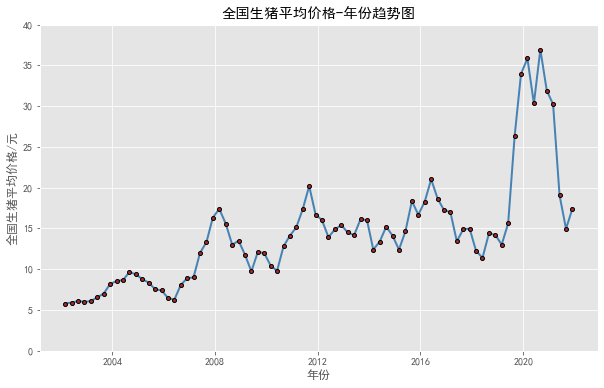

In [4]:
# 设置绘图风格
plt. style.use("ggplot")
# 设置中文编码和符号的正常显示
plt.rcParams["font.sans-serif"] = "SimHei"
plt.rcParams["axes.unicode_minus"] = False
# 设置图框的大小
fig = plt.figure(figsize = (10,6))
# 绘图
plt.ylim(0, 40)
plt.plot(data.loc[:,name[0]], # x轴数据
         data.loc[:,name[1]], # y轴数据
         linestyle = '-', # 折线类型
         linewidth = 2, # 折线宽度
         color = 'steelblue', # 折线颜色
         marker = 'o', # 点的形状
         markersize = 4, # 点的大小
         markeredgecolor='black', # 点的边框色
         markerfacecolor='brown') # 点的填充色
# 添加标题和坐标轴标签
plt.title('全国生猪平均价格-年份趋势图')
plt.xlabel('年份')
plt.ylabel('全国生猪平均价格/元')
plt.savefig('trend.png')
# 显示图形
plt.show()


In [5]:
cpi_cum = [100]
cpi = data0['cpi']
for i in range(1,20):
    c = cpi_cum[i-1]*cpi[i]/100
    cpi_cum.append(c)
data0['cpi_cum'] = cpi_cum
price_adj = []
price = data['猪肉价格']
for i in range(len(price)):
    c = i // 4
    p = price[i]*100/cpi_cum[c]
    price_adj.append(p)
data['调整猪肉价格'] = price_adj

In [6]:
data.to_csv("data.csv",index=False,header=True,na_rep="NULL")

In [7]:
data

,年月,猪肉价格,调整猪肉价格
0,2002-03-01,5.80,5.800000
1,2002-06-01,5.92,5.920000
2,2002-09-01,6.10,6.100000
3,2002-12-01,6.00,6.000000
4,2003-03-01,6.09,6.017787
...,...,...,...
75,2020-12-01,31.92,20.147874
76,2021-03-01,30.24,18.917204
77,2021-06-01,19.08,11.935855
78,2021-09-01,14.96,9.358511


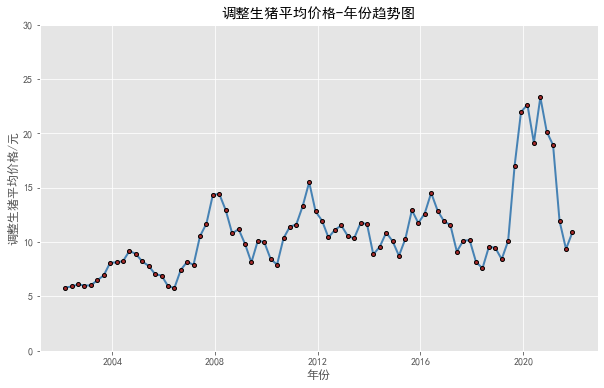

In [8]:
name = data.columns
# 设置绘图风格
plt. style.use("ggplot")
# 设置中文编码和符号的正常显示
plt.rcParams["font.sans-serif"] = "SimHei"
plt.rcParams["axes.unicode_minus"] = False
# 设置图框的大小
fig = plt.figure(figsize = (10,6))
# 绘图
plt.ylim(0, 30)
plt.plot(data.loc[:,name[0]], # x轴数据
         data.loc[:,name[2]], # y轴数据
         linestyle = '-', # 折线类型
         linewidth = 2, # 折线宽度
         color = 'steelblue', # 折线颜色
         marker = 'o', # 点的形状
         markersize = 4, # 点的大小
         markeredgecolor='black', # 点的边框色
         markerfacecolor='brown') # 点的填充色
# 添加标题和坐标轴标签
plt.title('调整生猪平均价格-年份趋势图')
plt.xlabel('年份')
plt.ylabel('调整生猪平均价格/元')
plt.savefig('trend1.png')
# 显示图形
plt.show()


In [9]:
datap = data[[name[0],name[2]]]
datap

,年月,调整猪肉价格
0,2002-03-01,5.800000
1,2002-06-01,5.920000
2,2002-09-01,6.100000
3,2002-12-01,6.000000
4,2003-03-01,6.017787
...,...,...
75,2020-12-01,20.147874
76,2021-03-01,18.917204
77,2021-06-01,11.935855
78,2021-09-01,9.358511


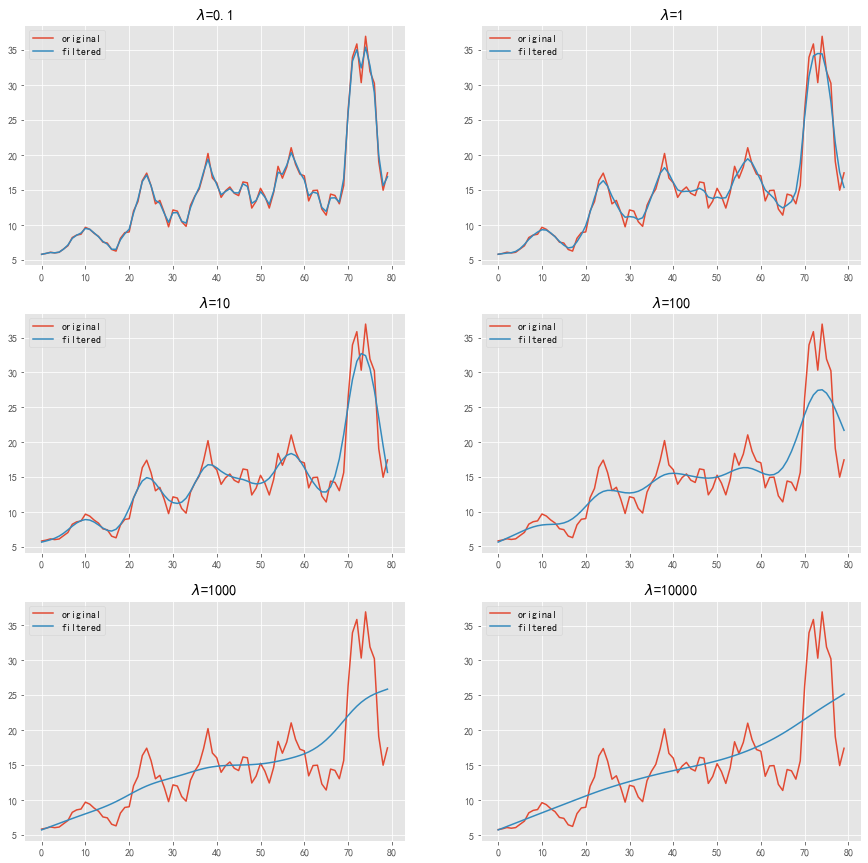

In [12]:
def hp(y, lamb=10):
    def D_matrix(N):
        #(N-1,N) 元素全为0
        D = np.zeros((N-1,N))
        #后(N-1,N-1)对角线元素置1
        D[:,1:] = np.eye(N-1)
        #前(N-1,N-1)对角线元素置-1
        D[:,:-1] -= np.eye(N-1)
        """D1
        [[-1.  1.  0. ...  0.  0.  0.]
         [ 0. -1.  1. ...  0.  0.  0.]
         [ 0.  0. -1. ...  0.  0.  0.]
         ...
         [ 0.  0.  0. ...  1.  0.  0.]
         [ 0.  0.  0. ... -1.  1.  0.]
         [ 0.  0.  0. ...  0. -1.  1.]]
        """
        return D

    N = len(ts)
    D1 = D_matrix(N)
    D2 = D_matrix(N-1)
    #@是矩阵乘法  D2.shape = (N-2,N-1) D1.shape = (N-1,N) 所以 D.shape = (N-2,N) 
    D = D2 @ D1
    # G = [i+λF]*-1Y
    #np.linalg.inv为矩阵求逆 套用公式 D.T@D = F F.shape=(N,N)
    # print(D.T@D)
    g = np.linalg.inv((np.eye(N)+lamb*D.T@D))@ ts
    c = lamb*D.T@D@g
    return g,c

N = len(datap)
# t = np.linspace(1,10,N)
# ts = np.sin(t) + np.cos(20*t) + np.random.randn(N)*0.1
ts = price
plt.figure(figsize=(15,15))

#尝试不同的λ
for i,l in enumerate([0.1,1,10,100,1000, 10000]):
    plt.subplot(3,2,i+1)
    g,c = hp(ts,l)
    plt.plot(ts, label='original')
    plt.plot(g, label='filtered')
    plt.legend()
    plt.title('$\lambda$='+str(l))
    
# plt.savefig('hp.pdf')
plt.show()

In [17]:
g,c = hp(price,1600)
data['hp_g'] = g
data['hp_c'] = c
data

,年月,猪肉价格,调整猪肉价格,hp_g,hp_c
0,2002-03-01,5.80,5.800000,5.842065,-0.042065
1,2002-06-01,5.92,5.920000,6.025425,-0.105425
2,2002-09-01,6.10,6.100000,6.208758,-0.108758
3,2002-12-01,6.00,6.000000,6.391972,-0.391972
4,2003-03-01,6.09,6.017787,6.574908,-0.557122
...,...,...,...,...,...
75,2020-12-01,31.92,20.147874,15.530246,4.617627
76,2021-03-01,30.24,18.917204,15.724898,3.192307
77,2021-06-01,19.08,11.935855,15.898734,-3.962879
78,2021-09-01,14.96,9.358511,16.061742,-6.703231


In [14]:
data.to_csv("data.csv",index=False,header=True,na_rep="NULL")

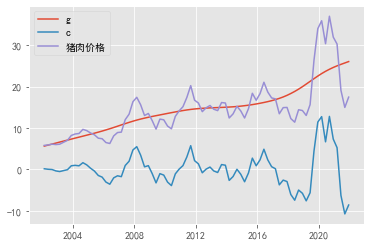

In [15]:
plt.plot(data.loc[:,'年月'], # x轴数据
         data.loc[:,'hp_g'], # y轴数据 
         label='g')
plt.plot(data.loc[:,'年月'], # x轴数据
         data.loc[:,'hp_c'], # y轴数据 
         label='c')
plt.plot(data.loc[:,'年月'], # x轴数据
         data.loc[:,'猪肉价格'], # y轴数据 
         label='猪肉价格')
plt.legend()
# plt.savefig('gc.pdf')

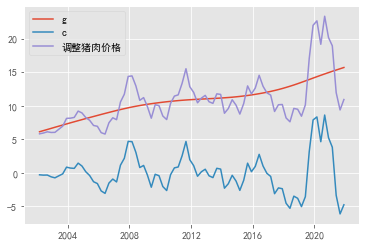

In [16]:
ts = price_adj
g,c = hp(ts,l)
plt.plot(data.loc[:,'年月'],g,label='g')
plt.plot(data.loc[:,'年月'],c, label='c')
plt.plot(data.loc[:,'年月'],data.loc[:,'调整猪肉价格'], label='调整猪肉价格')
plt.legend()
# plt.savefig('gc_adj.pdf')

In [18]:
kstest(c, 'norm')

KstestResult(statistic=0.2144740150301165, pvalue=0.0010408599470181912)

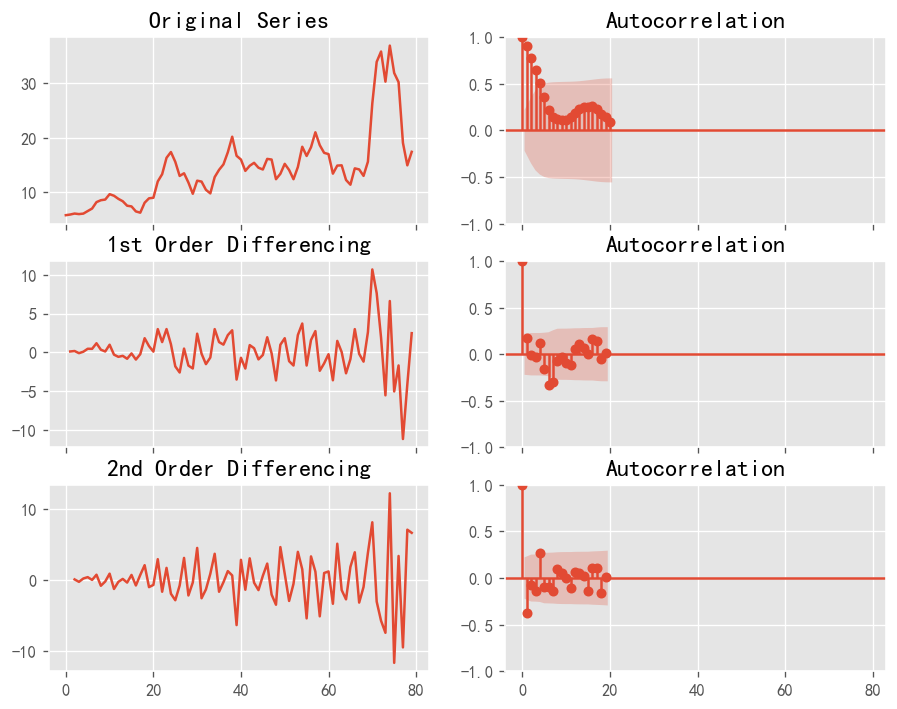

In [21]:

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

df = data[name[1]]

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
plot_acf(df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1])

# plt.savefig('d.pdf')
plt.show()


D:\py\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


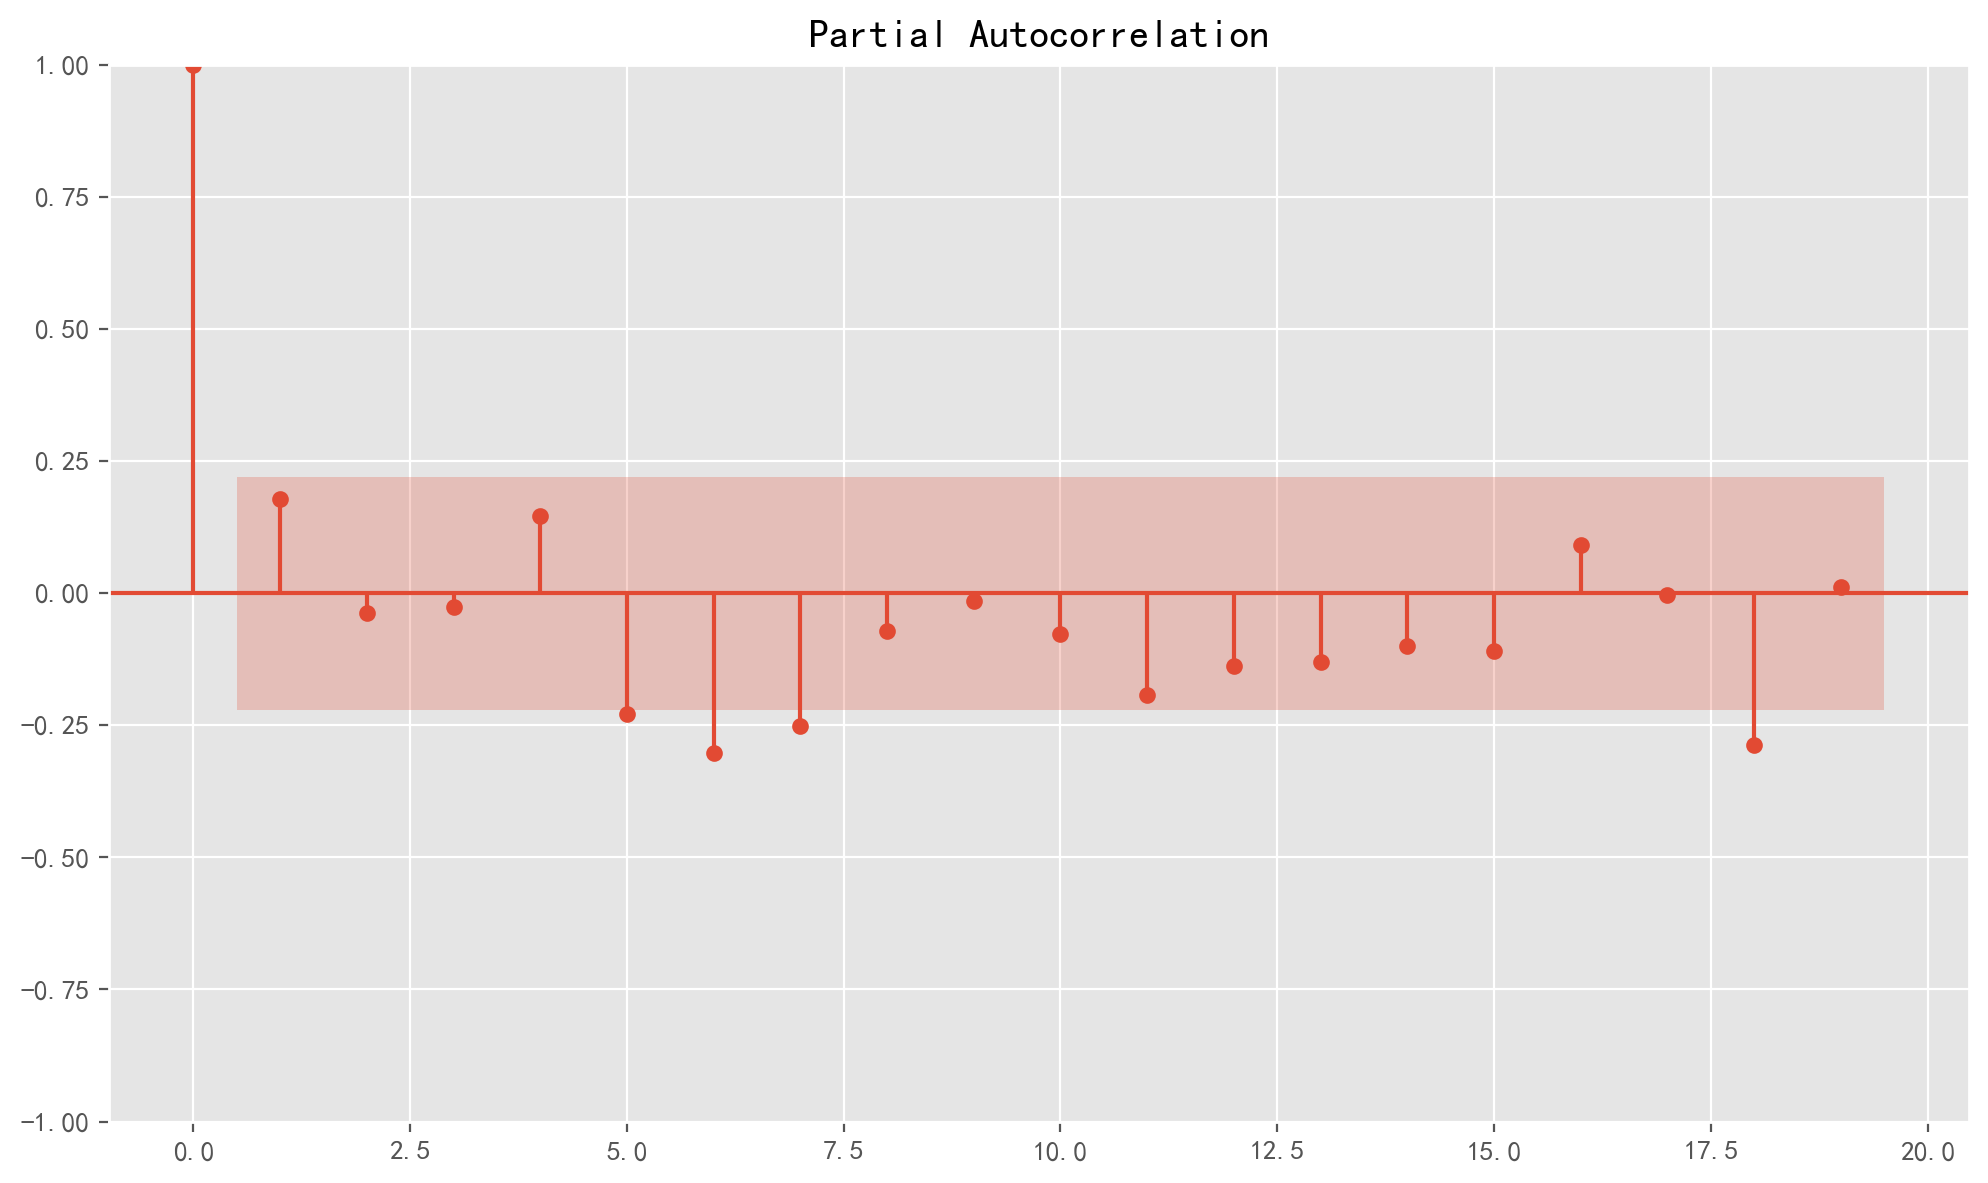

In [22]:
plt.rcParams.update({'figure.figsize':(12,7), 'figure.dpi':200})
plot_pacf(data_diff)
plt.savefig('p.pdf')
plt.show()

In [23]:
from statsmodels.tsa.stattools import adfuller
def adf_test(ts):
    adftest = adfuller(ts, autolag='AIC')
    adf_res = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])

    for key, value in adftest[4].items():
        adf_res['Critical Value (%s)' % key] = value
    return adf_res
adf_test(data_diff)

Test Statistic                 -4.986603
p-value                         0.000024
Lags Used                      11.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64

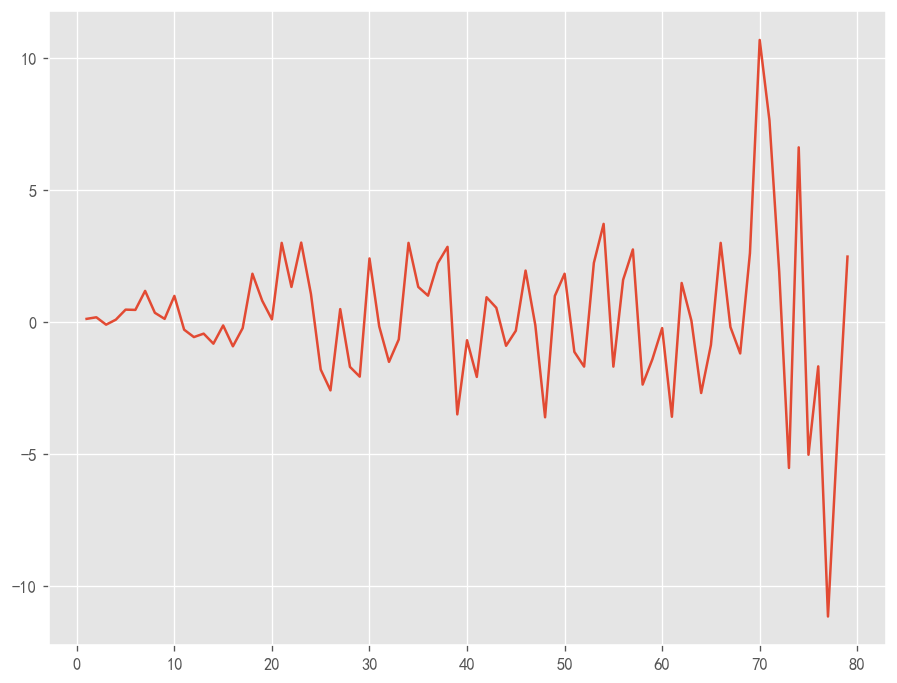

In [20]:
data_diff = df.diff()
data_diff = data_diff.dropna()
plt.plot(data_diff)
plt.show() 

In [24]:
from statsmodels.tsa.stattools import adfuller
adfuller(data_diff.dropna())

(-4.986603319334445,
 2.3588673886572885e-05,
 11,
 67,
 {'1%': -3.5319549603840894,
  '5%': -2.905755128523123,
  '10%': -2.5903569458676765},
 324.65299645850484)

In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acor = acorr_ljungbox(data_diff, lags = 10)
print(acor.to_latex(index=True))

\begin{tabular}{lrr}
\toprule
{} &    lb\_stat &  lb\_pvalue \\
\midrule
1  &   2.540868 &   0.110934 \\
2  &   2.542808 &   0.280438 \\
3  &   2.632786 &   0.451771 \\
4  &   3.945452 &   0.413438 \\
5  &   5.997015 &   0.306510 \\
6  &  15.313093 &   0.017956 \\
7  &  23.381720 &   0.001462 \\
8  &  23.887319 &   0.002394 \\
9  &  23.987902 &   0.004320 \\
10 &  24.733571 &   0.005874 \\
\bottomrule
\end{tabular}



<ipython-input-26-edf2b65319f7>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acf.show()


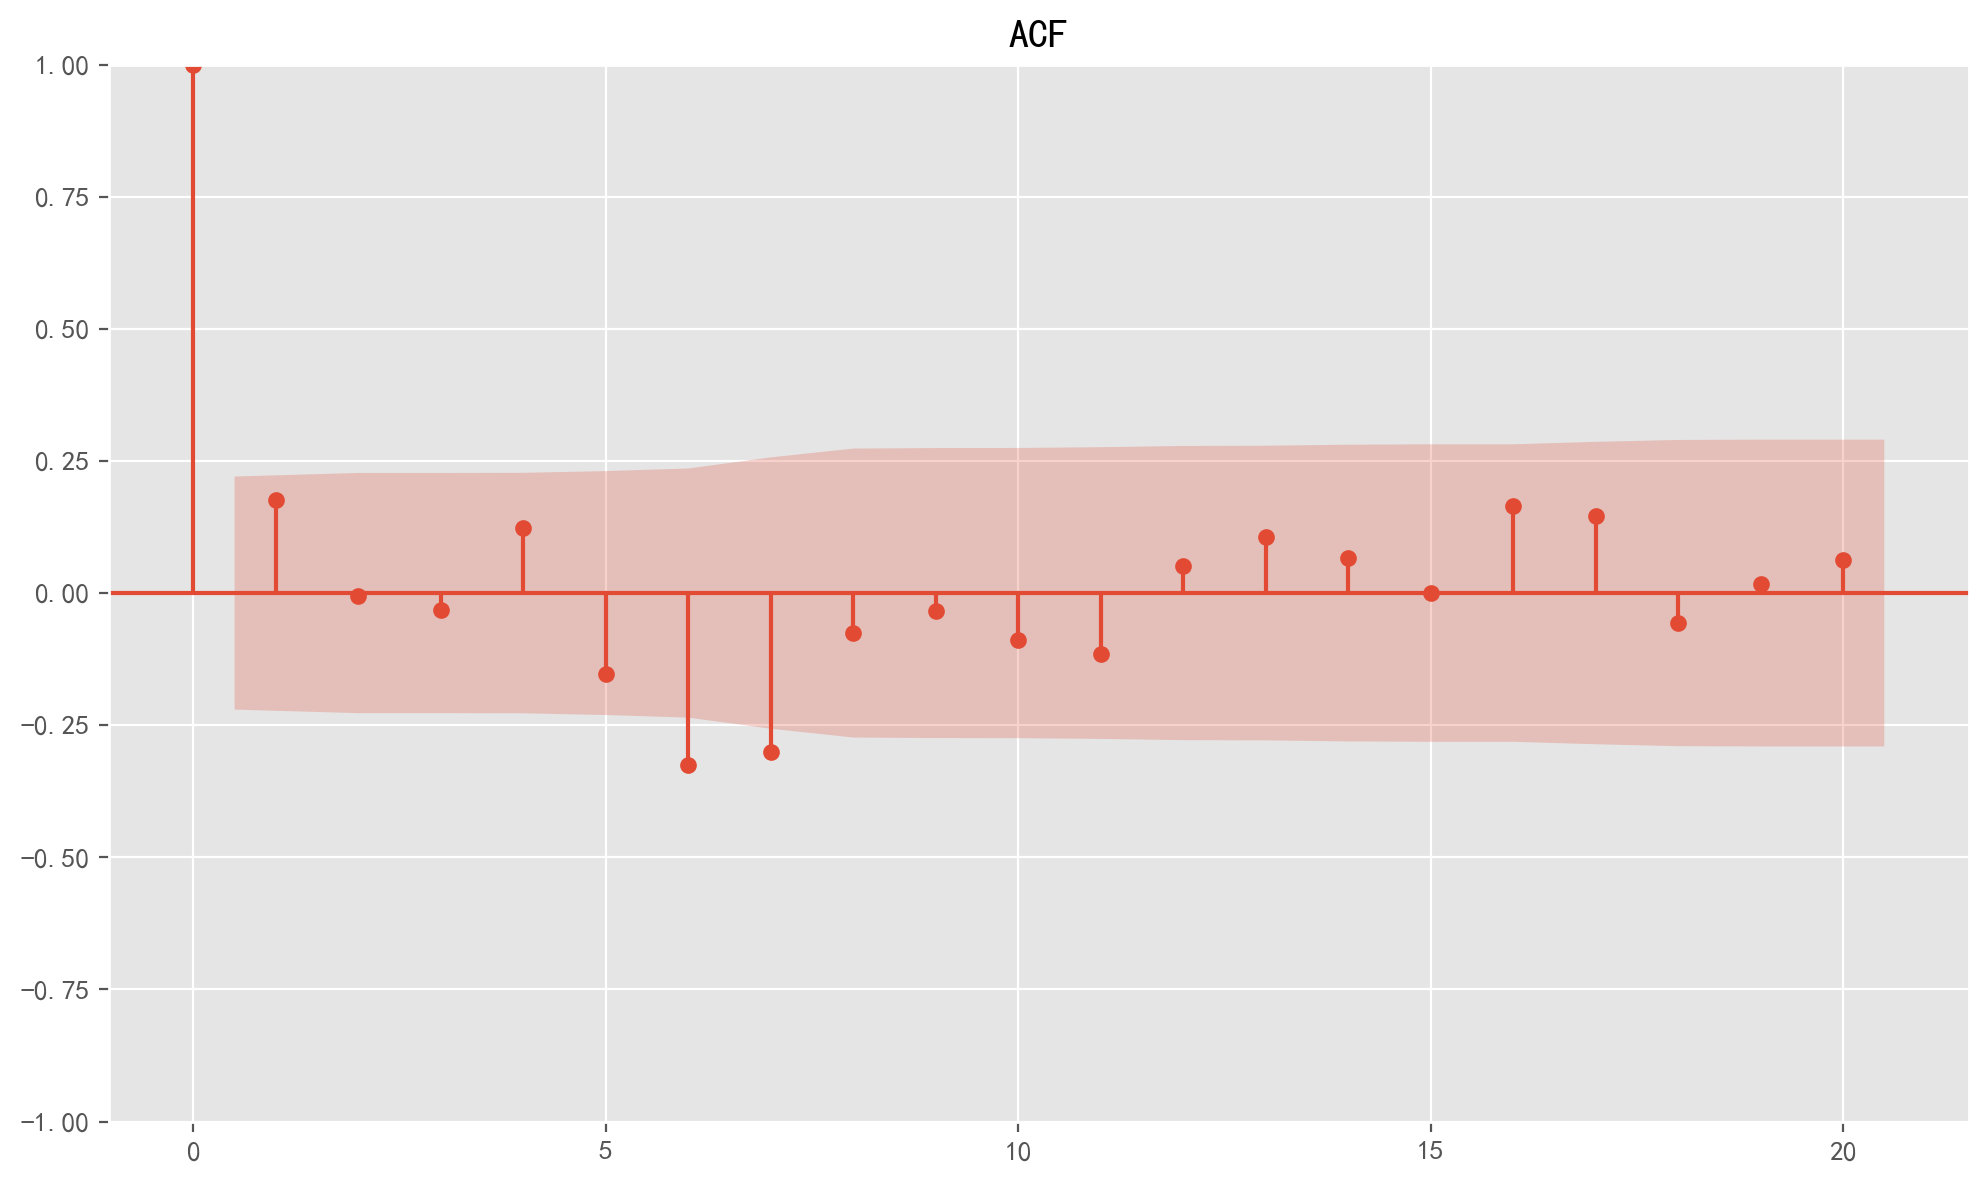

In [26]:
acf = plot_acf(data_diff, lags=20)
plt.title('ACF')
acf.savefig('q.pdf')
acf.show()

In [101]:
import statsmodels.tsa.stattools as st

model = st.arma_order_select_ic(data_diff, max_ar=10, max_ma=10, ic=['aic', 'bic', 'hqic'])

model.aic_min_order #返回一个元组，分别为p值和q值

D:\py\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\py\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\py\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\py\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\py\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxim

(5, 3)

In [30]:
import statsmodels.tsa.stattools as st

model = st.arma_order_select_ic(data_diff, max_ar=8, max_ma=8, ic=['aic', 'bic', 'hqic'])

model.aic_min_order #返回一个元组，分别为p值和q值

D:\py\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\py\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\py\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\py\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\py\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxim

(5, 3)

In [27]:
from statsmodels.tsa.arima.model import ARIMA

df.rename('price',inplace=True)
model = ARIMA(df, order=(5,1,3))
result = model.fit()
result.summary()

D:\py\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\py\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\py\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   80
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -181.130
Date:                Sun, 10 Apr 2022   AIC                            380.260
Time:                        18:15:45   BIC                            401.585
Sample:                             0   HQIC                           388.803
                                 - 80                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4157      0.240      5.901      0.000       0.945       1.886
ar.L2         -1.1953      0.388     -3.080      0.002      -1.956      -0.435
ar.L3          0.6124      0.344      1.778      0.075      -0.063       1.288
ar.L4          0.1140      0.199      0.573      0.567      -0.276       0.504
ar.L5         -0.3766      0.142     -2.645      0.008      -0.656      -0.098
ma.L1         -1.4221      0.265     -5.360      0.000      -1.942      -0.902
ma.L2          1.2043      0.405      2.973      0.003       0.410       1.998
ma.L3         -0.5999      0.308     -1.945      0.052      -1.204       0.005
sigma2         5.5412      0.782      7.085      0.000       4.008       7.074
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                13.78
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               9.79   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

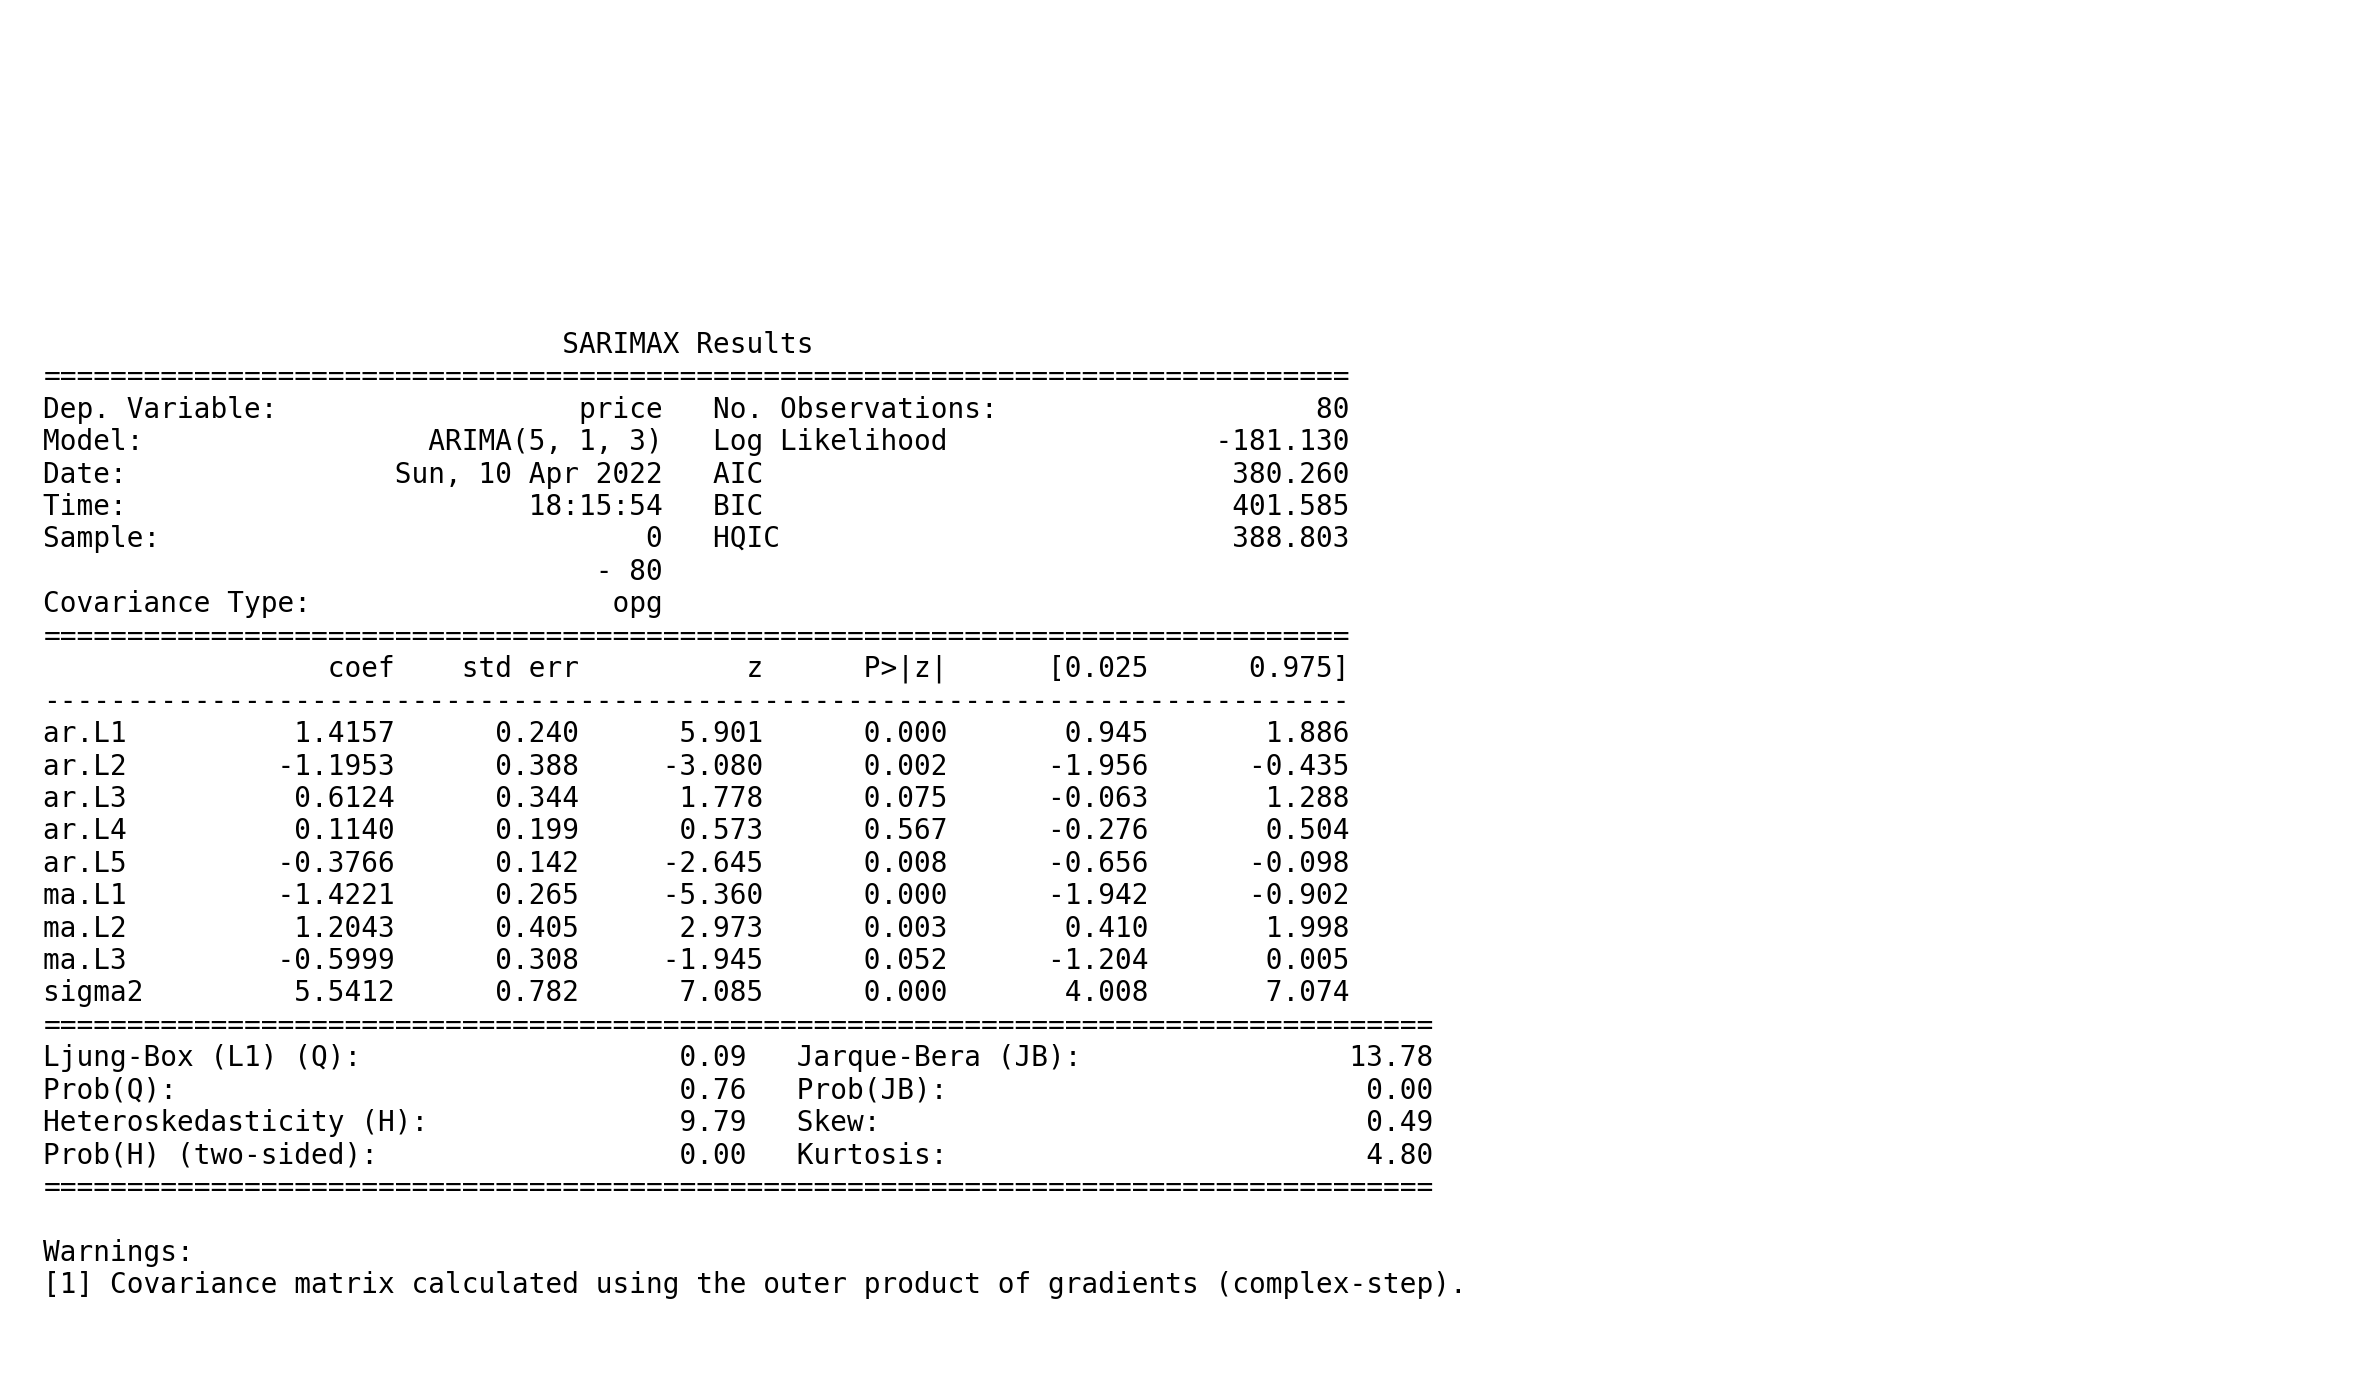

In [28]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(result.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output.pdf')

D:\py\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
D:\py\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


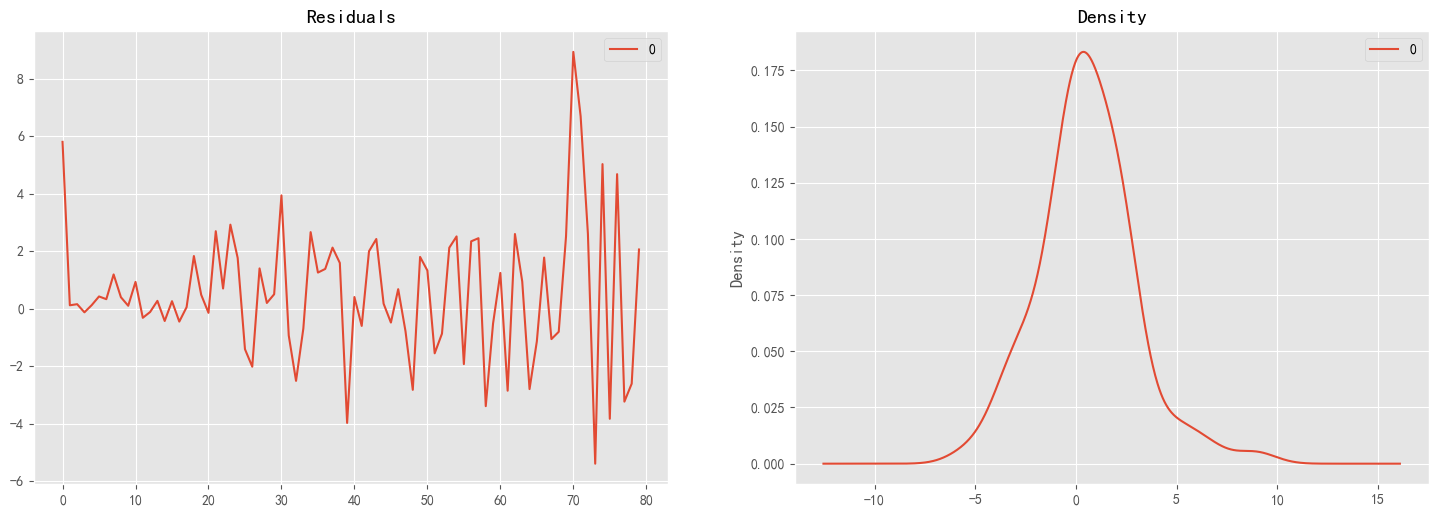

In [32]:
plt.rcParams.update({'figure.figsize':(18,6), 'figure.dpi':100})
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.savefig('res.pdf')
plt.show()

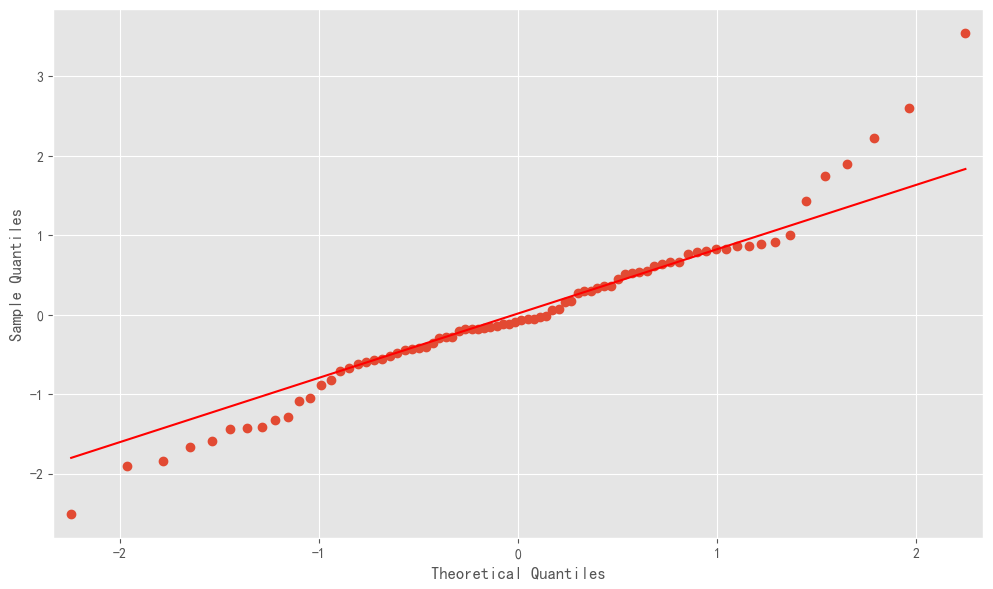

In [33]:
resid = result.resid
plt.rcParams.update({'figure.figsize':(12,7), 'figure.dpi':100})
from statsmodels.graphics.api import qqplot

qqplot(resid, line='q', fit=True)
# plt.savefig('qq.pdf')
plt.show()

In [34]:
from scipy import stats 
stats.normaltest(resid)

NormaltestResult(statistic=8.880217789978431, pvalue=0.01179465407108995)

In [36]:
pred = result.predict(start=1, end =len(data) + 5 )

In [37]:
print(len(pred))

print(pred[-5:])

85
81    13.361578
82    13.759277
83    19.540019
84    24.227725
85    24.137864
Name: predicted_mean, dtype: float64


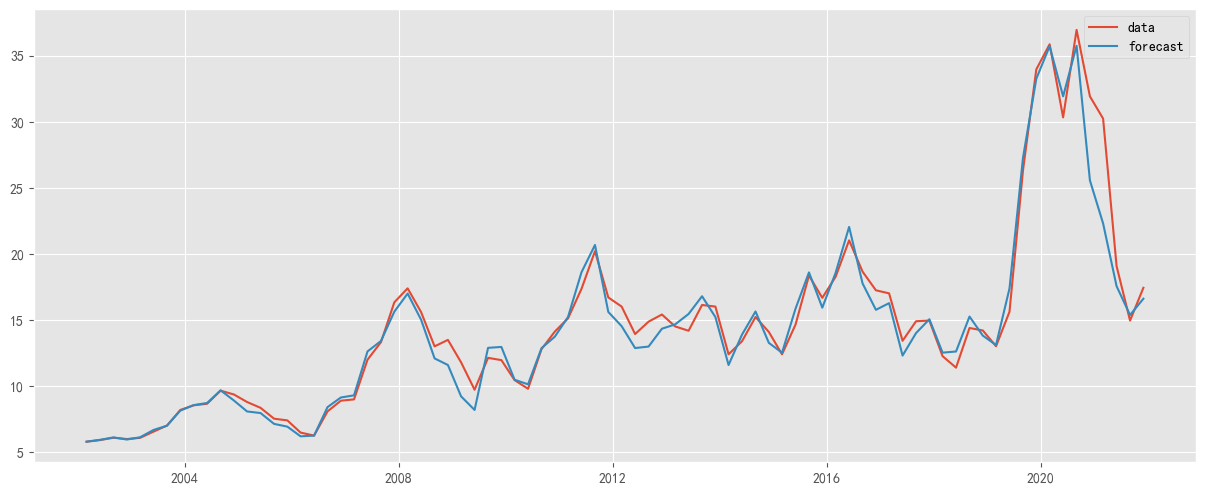

In [124]:
yhat = result.predict(start=1, end =len(data) )
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':100})
plt.plot(data.loc[:,'年月'],df, label='data')
plt.plot(data.loc[:,'年月'],yhat, label='forecast')
plt.legend()
# plt.savefig('forecast.pdf')
plt.show()

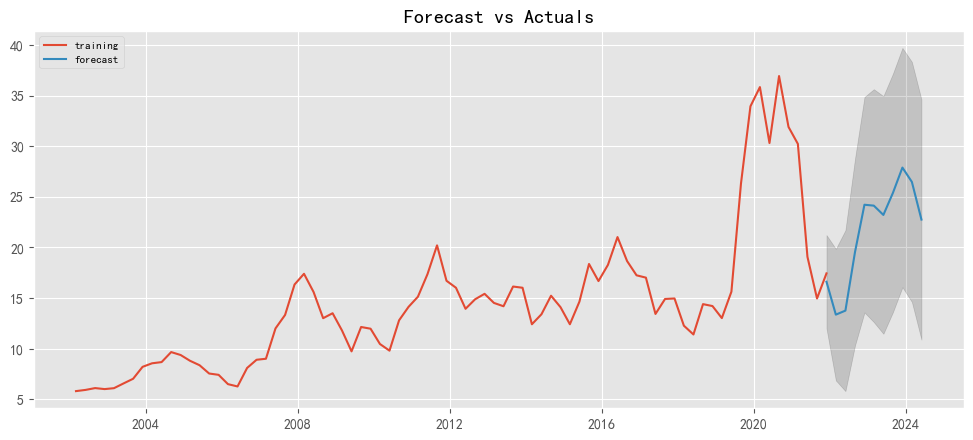

In [121]:

# Create Training and Test
train = date[:80]#['猪肉价格']
test = date[79:]
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':100})
# Forecast
fc= result.predict(start=len(data), end =len(data) + 10 )  # 95% conf
pred_dynamic = result.get_prediction(start=len(data),end =len(data) + 10,  dynamic=True, full_results=True, alpha=0.05)
pred_dynamic_ci = pred_dynamic.conf_int()

# Make as pandas series
fc_series = pd.Series(list(fc), index=list(date[79:]['年月']))
lower_series = pd.Series(pred_dynamic_ci.values[:, 0], index=list(date[79:]['年月']))
upper_series = pd.Series(pred_dynamic_ci.values[:, 1], index=list(date[79:]['年月']))

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.loc[:,'年月'],train.loc[:,'猪肉价格'], label='training')
# plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
# plt.savefig('predict.pdf')
plt.show()

In [42]:
print(result.forecast(10, alpha=0.05))

80    16.614903
81    13.361578
82    13.759277
83    19.540019
84    24.227725
85    24.137864
86    23.218664
87    25.405156
88    27.901545
89    26.483489
Name: predicted_mean, dtype: float64


In [72]:
pred_dynamic = result.get_prediction(start=len(data),end =len(data) + 9,  dynamic=True, full_results=True, alpha=0.05)
pred_dynamic_ci = pred_dynamic.conf_int()

pred_dynamic_ci

,lower price,upper price
80,12.001211,21.228596
81,6.857784,19.865371
82,5.802475,21.716080
83,10.310408,28.769630
84,13.576019,34.879431
85,12.624226,35.651503
86,11.470768,34.966560
87,13.616033,37.194279
88,16.072789,39.730302
89,14.615920,38.351058


In [93]:
date = pd.read_excel('data.xls')
# date = date['年月']
# date.set_index('年月',inplace=True)
date

,年月,猪肉价格
0,2002-03-01,5.80
1,2002-06-01,5.92
2,2002-09-01,6.10
3,2002-12-01,6.00
4,2003-03-01,6.09
...,...,...
85,2023-06-01,NaN
86,2023-09-01,NaN
87,2023-12-01,NaN
88,2024-03-01,NaN


In [114]:
train

,年月,猪肉价格
0,2002-03-01,5.80
1,2002-06-01,5.92
2,2002-09-01,6.10
3,2002-12-01,6.00
4,2003-03-01,6.09
...,...,...
76,2021-03-01,30.24
77,2021-06-01,19.08
78,2021-09-01,14.96
79,2021-12-01,17.44


In [111]:
fc

80    16.614903
81    13.361578
82    13.759277
83    19.540019
84    24.227725
85    24.137864
86    23.218664
87    25.405156
88    27.901545
89    26.483489
Name: predicted_mean, dtype: float64

In [75]:
fc_series

年月
2022-03-01   NaN
2022-06-01   NaN
2022-09-01   NaN
2022-12-01   NaN
2023-03-01   NaN
2023-06-01   NaN
2023-09-01   NaN
2023-12-01   NaN
2024-03-01   NaN
2024-06-01   NaN
Name: predicted_mean, dtype: float64